In [1]:
import numpy as np
import pandas as pd
%pip install krippendorff
import krippendorff
import matplotlib.pyplot as plt
%pip install squarify
import squarify
%pip install plotly
import plotly.graph_objects as go
import plotly.express as px
%pip install pywaffle
from pywaffle import Waffle
import seaborn as sns
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# merging batch 1 and 2 csv files into one data frame
df = pd.concat(
    map(pd.read_csv, ['Batch_342086_batch_results.csv', 'Batch_342087_batch_results.csv']), ignore_index=True)
#drop unneeded column
df.drop(columns=["LifetimeInSeconds","Title","HITId","HITTypeId","Description","Keywords","Reward","CreationTime","MaxAssignments","RequesterAnnotation",
                 "AssignmentDurationInSeconds","AutoApprovalDelayInSeconds","Expiration","NumberOfSimilarHITs",
                 "AssignmentId","AssignmentStatus","AutoApprovalTime","ApprovalTime","Approve","Reject",
                "AcceptTime","SubmitTime","RejectionTime","RequesterFeedback","LifetimeApprovalRate","Last30DaysApprovalRate",
                "Last7DaysApprovalRate","Input.Spalte1", "Input.FormalRuleHtml","Input.SentenceHtml","Input.ParagraphHTML"], inplace=True)

print("Number of HIT responses:", len(df.index))

Number of HIT responses: 168


In [3]:
#Calcukate Average Validation Times

#Task 1 + (Taks 2 if constarint)
print("Average time per HIT (overall):",round(df['WorkTimeInSeconds'].mean()/60,2),"minutes")

#Task 1 + Task 2 for sentences marked as constraints
print("Average time per HIT (constraints, Task1 & Task2)",round(df[df['Answer.ConstarintYes.ConstarintYes']==True]['WorkTimeInSeconds'].mean()/60,2),"minutes")

#identify a sentence is not a constraint
print("Average time per HIT (non-constraints, only Task 1)",round(df[df['Answer.ConstarintYes.ConstarintYes']==False]['WorkTimeInSeconds'].mean()/60,2),"minutes")


Average time per HIT (overall): 1.78 minutes
Average time per HIT (constraints, Task1 & Task2) 2.43 minutes
Average time per HIT (non-constraints, only Task 1) 0.91 minutes


In [4]:
#Preprocess dataitems 

#constarint from nodeset was identified as constraint but not relevenat -> changing answer to TRUE
df.loc[df["Answer.commentConstraint"].str.contains("You can argue, it is a constraint. But this just describes what is already in the NodeSet.")==True,"Answer.ConstarintNo.ConstarintNo"]=False
df.loc[df["Answer.commentConstraint"].str.contains("You can argue, it is a constraint. But this just describes what is already in the NodeSet.")==True,"Answer.ConstarintYes.ConstarintYes"]=True

#constarint identified but not from Machinery, general opc ua constarint
df.loc[df["Answer.commentConstraint"].str.contains("This is a constraint, but comming from the base spec. So nothing specific to the CS.")==True,"Answer.ConstarintYes.ConstarintYes"]=True
df.loc[df["Answer.commentConstraint"].str.contains("This is a constraint, but comming from the base spec. So nothing specific to the CS.")==True,"Answer.ConstarintUncertain.ConstarintUncertain"]=False


In [5]:
#Summarize Validation Columns
column_constaint=[]
column_rule=[]
for indes,row in df.iterrows():
    if(row['Answer.ConstarintYes.ConstarintYes']==True):
        column_constaint.append('True')
        if(row['Answer.RuleValidYes.RuleValidYes']==True):
            column_rule.append('True')
            continue;
        if(row['Answer.RuleValidNo.RuleValidNo']==True):
            column_rule.append('False')
            continue;
        if(row['Answer.RuleValidUncertain.RuleValidUncertain']==True):
            column_rule.append('Uncertain')
            continue;
        column_rule.append('')
        continue;
    if(row['Answer.ConstarintNo.ConstarintNo']==True):
        column_constaint.append('False')
        column_rule.append('')
        continue;
    if(row['Answer.ConstarintUncertain.ConstarintUncertain']==True):
        column_constaint.append('Uncertain')
        column_rule.append('')
        continue;
        
df['isConstraint'] = column_constaint
df['isRuleValid'] = column_rule
df.drop(columns=['Answer.ConstarintYes.ConstarintYes','Answer.ConstarintNo.ConstarintNo','Answer.ConstarintUncertain.ConstarintUncertain',
               'Answer.RuleValidYes.RuleValidYes','Answer.RuleValidUncertain.RuleValidUncertain','Answer.RuleValidNo.RuleValidNo'], inplace=True)

In [6]:
#Number of submitted HITs per expert
df['WorkerId'].value_counts()

A2OL2EL7XOZA12    30
A3N4ICJ8JZADUR    30
A2BFTDCHOCAGDB    29
A2BKRT5YKLQU20    28
A2CRF3VDA2RXR5    26
A1WKDRFVZJ94XQ    25
Name: WorkerId, dtype: int64

In [7]:
df.head()

WorkerId  WorkTimeInSeconds  Input.ID  \
0  A2CRF3VDA2RXR5                 21         2   
1  A2OL2EL7XOZA12                176         2   
2  A1WKDRFVZJ94XQ                 21         2   
3  A2OL2EL7XOZA12                 92         4   
4  A1WKDRFVZJ94XQ                 15         4   

                                      Input.Sentence  \
0  If the information for optional nodes (e.g. Pr...   
1  If the information for optional nodes (e.g. Pr...   
2  If the information for optional nodes (e.g. Pr...   
3  This building block provides the capabilities ...   
4  This building block provides the capabilities ...   

                               Input.OnlineReference  \
0  https://reference.opcfoundation.org/Machinery/...   
1  https://reference.opcfoundation.org/Machinery/...   
2  https://reference.opcfoundation.org/Machinery/...   
3  https://reference.opcfoundation.org/Machinery/...   
4  https://reference.opcfoundation.org/Machinery/...   

                                     Input.Paragraph  Input.Constraint  \
0  \nIf the information for optional nodes (e.g. ...              True   
1  \nIf the information for optional nodes (e.g. ...              True   
2  \nIf the information for optional nodes (e.g. ...              True   
3  \nThis building block provides the capabilitie...             False   
4  \nThis building block provides the capabilitie...             False   

  Input.ExtendsTheInformationProvidedByT Input.ConstraintClassification  \
0                                   True         VariableTypeDefinition   
1                                   True         VariableTypeDefinition   
2                                   True         VariableTypeDefinition   
3                                  False                              -   
4                                  False                              -   

                      Input.RuleTypes  \
0  NoReadonlyVariablesWithoutValue_GR   
1  NoReadonlyVariablesWithoutValue_GR   
2  NoReadonlyVariablesWithoutValue_GR   
3                                   -   
4                                   -   

                                 Input.FormalRuleSet  Input.BATCH  \
0  There should not exist any nodes within the Ma...            2   
1  There should not exist any nodes within the Ma...            2   
2  There should not exist any nodes within the Ma...            2   
3                                                  -            2   
4                                                  -            2   

  Answer.RuleSetDefect                           Answer.commentConstraint  \
0                  NaN                                                NaN   
1                  NaN                                                NaN   
2                  NaN                                                NaN   
3                  NaN  This is an introduction sentence meant to expl...   
4                  NaN                                                NaN   

                       Answer.commentRuleValidatiion isConstraint isRuleValid  
0                                                NaN        False              
1  This only applies to Instances\r\rHowever, "no...         True        True  
2                                                NaN         True              
3                                                NaN        False              
4                                                NaN        False

In [8]:
#create new data set with unique sentences, where the calculated results will be added 
sentences=df[['Input.ID','Input.Constraint','Input.BATCH']].drop_duplicates(inplace=False)
sentences["isConstraintMajority"] = np.nan
sentences["isRuleValidtMajority"] = np.nan
sentences["RuleDefectMajority"] = np.nan
sentences["Evaluators"] = 0
sentences["SentenceNum"] = 0
sentences = sentences.astype({"isConstraintMajority": str, "isRuleValidtMajority": str,"RuleDefectMajority":str, "Input.Constraint":str})

In [9]:

#check majority vote for each sentence
num=1;
for index, row in sentences.iterrows():
    sentences.at[index,"SentenceNum"] = num
    num+=1
    answers=df[df["Input.ID"]==row["Input.ID"]]
    sentences.at[index,"Evaluators"] = len(answers)
    sentences.at[index,"isConstraintMajority"] = ",".join(answers['isConstraint'].mode())
    if("True" in sentences.at[index,"isConstraintMajority"]): #constraiint
        majorityTask2 = answers[answers.isRuleValid != ""].isRuleValid.mode()
        sentences.at[index,"isRuleValidtMajority"] = ",".join(majorityTask2)
        if(sentences.at[index,"isRuleValidtMajority"]): #rule not valid
            sentences.at[index,"RuleDefectMajority"] = ",".join(answers[answers.isRuleValid == "False"]["Answer.RuleSetDefect"].mode())
        else: #rule valid
            sentences.at[index,"RuleDefectMajority"] = ""
            
    else: #not constraint
        sentences.at[index,"isRuleValidtMajority"] = ""
        sentences.at[index,"RuleDefectMajority"] = ""

In [10]:
sentences.head()

Input.ID Input.Constraint  Input.BATCH isConstraintMajority  \
0         2             True            2                 True   
3         4            False            2                False   
5         6             True            2                False   
6         8             True            2                 True   
9        12             True            2                 True   

  isRuleValidtMajority RuleDefectMajority  Evaluators  SentenceNum  
0                 True                              3            1  
3                                                   2            2  
5                                                   1            3  
6                 True                              3            4  
9                 True                              2            5

In [11]:
#Average number of responses per HIT
print("Average number of evaluaters per sentence:", round(sentences["Evaluators"].mean()))
print("Number of Evaluations:")
sentences["Evaluators"].value_counts()

Average number of evaluaters per sentence: 3
Number of Evaluations:


3    44
2    11
4     3
1     2
Name: Evaluators, dtype: int64

In [12]:
print("Agreements Experts vs Authors")
print("\n","### Task 1 ###","\n")

#Caluclate percentage of data items where a majority vote could be calculated 
majority_sentences = sentences.loc[~sentences["isConstraintMajority"].str.contains(",")]
print("Constraint verifications, where a majority vote was established:", round(len(majority_sentences)/60*100,2),"%")

#Agreement for those data items wehre majority is available (experts vs authors)
print("Constraint Agreement between authors and expert majority",round(
    len(majority_sentences[majority_sentences["Input.Constraint"] == majority_sentences["isConstraintMajority"]])
    /len(majority_sentences)*100,2),"%")

#Agreement for all data items where at least one expert agrees with the authors
sentences["Constraint Agreement between authors and at lest one expert"] = sentences.apply(lambda x: x["Input.Constraint"] in x["isConstraintMajority"], axis = 1)
print("Agreement between authors and at least one expert",
      round(len(sentences.loc[sentences["Constraint Agreement between authors and at lest one expert"] == True])
            /60*100,2),"%")
sentences.drop(columns=["Constraint Agreement between authors and at lest one expert"],inplace=True)
print("\n","### Task 2 ###","\n")

#Rule Validation Majorty for data items identified as constraints by the majority  
majority_rules = sentences.loc[(~sentences.isRuleValidtMajority.str.contains(",")) & (sentences.isRuleValidtMajority != "")]
print("Rule Validations for which a majority vote was established:", round(len(majority_rules)/len(sentences.loc[sentences["isRuleValidtMajority"] != ""])*100,2),"%")
print("Agreement between authors and expert majority :", round(len(majority_rules[majority_rules["isRuleValidtMajority"]=="True"])/len(majority_rules)*100,2),"%")
print("Agreement between authors and at least one expert :", round(len(sentences[sentences["isRuleValidtMajority"].str.contains("True")])/len(sentences.loc[sentences["isRuleValidtMajority"] != ""])*100,2),"%")


Agreements Experts vs Authors

 ### Task 1 ### 

Constraint verifications, where a majority vote was established: 88.33 %
Constraint Agreement between authors and expert majority 56.6 %
Agreement between authors and at least one expert 61.67 %

 ### Task 2 ### 

Rule Validations for which a majority vote was established: 76.67 %
Agreement between authors and expert majority : 65.22 %
Agreement between authors and at least one expert : 70.0 %


In [13]:
#Agreement Authors <> Majority Vote

authors=majority_sentences["Input.Constraint"].tolist()
majority=majority_sentences["isConstraintMajority"].tolist()

reliability_data=[authors,majority]
print(" ### Task 1 ### ")
print("Agreement Authors <> Majority Vote ((Krippendorff's alpha score)):",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2)
)   



 ### Task 1 ### 
Agreement Authors <> Majority Vote ((Krippendorff's alpha score)): 0.03


In [14]:
print("Performance of each of the experts individually")
print("\n","### Task 1 ###","\n")

raters = df["WorkerId"].unique()
scores=[]
scores_t =[] #authors say it is contrsaint
scores_f= [] #authors say it is not a contrsaint
for rater in raters: 
    workerAsnwers = df[(df["WorkerId"] == rater)]
    score=0
    score_t=0 #authors say it is contrsaint
    score_f= 0  #authors say it is not a contrsaint
    for constraint in workerAsnwers["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(str(workerAsnwer['Input.Constraint'].values[0]) == workerAsnwer.isConstraint.values[0]):
            score+=1
            if (workerAsnwer['Input.Constraint'].values[0] ==True):
                score_t+=1
            else:
                score_f+=1
    print(rater,round(score/len(workerAsnwers),2),"(corectness score / agreement with authors)")
        
    print("agrees with authors for constraint",round(score_t/len(workerAsnwers[workerAsnwers['Input.Constraint']==True]),2))
    print("agrees with authors for non-constraint",round(score_f/len(workerAsnwers[workerAsnwers['Input.Constraint']==False]),2))
    print("")

    scores.append(score/len(workerAsnwers))
    scores_t.append(score_t/len(workerAsnwers[workerAsnwers['Input.Constraint']==True]))
    scores_f.append(score_f/len(workerAsnwers[workerAsnwers['Input.Constraint']==False]))   
    
print("Average correctness/agreement with authors:", round(sum(scores)/len(scores),2))
print("(constraint) Average correctness/agreement with authors:", round(sum(scores_t)/len(scores_t),2))
print("(non-constraint) Average correctness/agreement with authors:", round(sum(scores_f)/len(scores_f),2))

Performance of each of the experts individually

 ### Task 1 ### 

A2CRF3VDA2RXR5 0.73 (corectness score / agreement with authors)
agrees with authors for constraint 0.79
agrees with authors for non-constraint 0.57

A2OL2EL7XOZA12 0.7 (corectness score / agreement with authors)
agrees with authors for constraint 0.81
agrees with authors for non-constraint 0.44

A1WKDRFVZJ94XQ 0.68 (corectness score / agreement with authors)
agrees with authors for constraint 0.74
agrees with authors for non-constraint 0.5

A3N4ICJ8JZADUR 0.73 (corectness score / agreement with authors)
agrees with authors for constraint 1.0
agrees with authors for non-constraint 0.0

A2BKRT5YKLQU20 0.39 (corectness score / agreement with authors)
agrees with authors for constraint 0.45
agrees with authors for non-constraint 0.25

A2BFTDCHOCAGDB 0.34 (corectness score / agreement with authors)
agrees with authors for constraint 0.29
agrees with authors for non-constraint 0.5

Average correctness/agreement with authors: 

In [15]:
print("Performance of each of the experts individually")
print("\n","### Task 2 - Rule Validation ###","\n")

raters = df["WorkerId"].unique()
scores=[]
for rater in raters:
    workerAsnwers = df[df["WorkerId"] == rater]
    workerAsnwers = workerAsnwers[workerAsnwers["isRuleValid"] != ""]
    score=0
    for constraint in workerAsnwers["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        #print(True, workerAsnwer.isRuleValid.values[0])
        if(str(True) == workerAsnwer.isRuleValid.values[0]):
            score+=1    
    print(rater,round(score/len(workerAsnwers),2),"(corectness score / agreement with authors)")
    scores.append(score/len(workerAsnwers))
   
print("Average correctness:", round(sum(scores)/len(scores),2))

Performance of each of the experts individually

 ### Task 2 - Rule Validation ### 

A2CRF3VDA2RXR5 0.86 (corectness score / agreement with authors)
A2OL2EL7XOZA12 0.59 (corectness score / agreement with authors)
A1WKDRFVZJ94XQ 1.0 (corectness score / agreement with authors)
A3N4ICJ8JZADUR 0.55 (corectness score / agreement with authors)
A2BKRT5YKLQU20 0.78 (corectness score / agreement with authors)
A2BFTDCHOCAGDB 0.33 (corectness score / agreement with authors)
Average correctness: 0.68


In [16]:
#Using krippendorff alpha score to calculate agreement because the number of raters varies for the tasks 

print("Agreement among experts")
print("\n","### Task 1 ###","\n")

reliability_data=[]
for rater in df["WorkerId"].unique(): 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in df["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Overall Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2),
      "; Based on answers of", len(df["WorkerId"].unique()), "experts" 
)      

reliability_data=[]
for rater in df["WorkerId"].unique(): 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in df[df["Input.Constraint"]]["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("(constraints) Overall Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2)
) 
reliability_data=[]
for rater in df["WorkerId"].unique(): 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in df[~df["Input.Constraint"]]["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("(non-constraints) Overall Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2)
) 


print("\n")

#Batch 1
batch1=df[df["Input.BATCH"] == 1]
ratersB1 = batch1.WorkerId.unique() 
reliability_data=[]
for rater in ratersB1: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch1["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Batch 1 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2),
      "; Based on answers of", len(ratersB1), "experts" 
)  

batch1=df[(df["Input.Constraint"]) & (df["Input.BATCH"] == 1)]
ratersB1 = batch1.WorkerId.unique() 
reliability_data=[]
for rater in ratersB1: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch1["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("(constraints) Batch 1 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2)
)   

batch1=df[(~df["Input.Constraint"]) & (df["Input.BATCH"] == 1)]
ratersB1 = batch1.WorkerId.unique() 
reliability_data=[]
for rater in ratersB1: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch1["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("(non-constarints) Batch 1 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2)
)   

print("\n")
   
#Batch 2
batch2=df[df["Input.BATCH"] == 2]
ratersB2 = batch2.WorkerId.unique() 
reliability_data=[]
for rater in ratersB2: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch2["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Batch 2 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2),
      "; Based on answers of", len(ratersB2), "experts" 
) 

batch2=df[(df["Input.Constraint"]) & (df["Input.BATCH"] == 2)]
ratersB2 = batch2.WorkerId.unique() 
reliability_data=[]
for rater in ratersB2: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch2["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)
print("(constarints) Batch 2 Agreement (Krippendorff's alpha score)",round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2))


batch2=df[(~df["Input.Constraint"]) & (df["Input.BATCH"] == 2)]
ratersB2 = batch2.WorkerId.unique() 
reliability_data=[]
for rater in ratersB2: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch2["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

    
print("(non-constarints) Batch 2 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2)
)   



Agreement among experts

 ### Task 1 ### 

Overall Agreement (Krippendorff's alpha score) 0.19 ; Based on answers of 6 experts
(constraints) Overall Agreement (Krippendorff's alpha score) 0.23
(non-constraints) Overall Agreement (Krippendorff's alpha score) 0.08


Batch 1 Agreement (Krippendorff's alpha score) 0.06 ; Based on answers of 4 experts
(constraints) Batch 1 Agreement (Krippendorff's alpha score) 0.03
(non-constarints) Batch 1 Agreement (Krippendorff's alpha score) 0.17


Batch 2 Agreement (Krippendorff's alpha score) 0.37 ; Based on answers of 3 experts
(constarints) Batch 2 Agreement (Krippendorff's alpha score) 0.55
(non-constarints) Batch 2 Agreement (Krippendorff's alpha score) -0.09


In [17]:
## Agreement when Uncertain is Removed

print("Agreement among experts when Unceratin Answers are removed")
print("\n","### Task 1 ###","\n")

reliability_data=[]
for rater in df["WorkerId"].unique(): 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in df["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isConstraint.values.size!=0):
            if workerAsnwer.isConstraint.values[0]=="Uncertain":
                answers_current_rater.append(np.nan)
            else:    
                answers_current_rater.append(workerAsnwer.isConstraint.values[0])
        else:
            answers_current_rater.append(np.nan)
    reliability_data.append(answers_current_rater)

print("Overall Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),2),
      "; Based on answers of", len(df["WorkerId"].unique()), "experts" 
)      



Agreement among experts when Unceratin Answers are removed

 ### Task 1 ### 

Overall Agreement (Krippendorff's alpha score) 0.2 ; Based on answers of 6 experts


In [18]:
print("Agreement among experts")
print("\n","### Task 2 - Rule Validation ###","\n")

reliability_data=[]
for rater in df["WorkerId"].unique(): 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in df["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isRuleValid.values.size!=0):
            if(workerAsnwer.isRuleValid.values[0] ==''):
                answers_current_rater.append(np.nan)
            else:
                answers_current_rater.append(workerAsnwer.isRuleValid.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Overall Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),6),
      "; Based on answers of", len(df["WorkerId"].unique()), "experts" 
)      
       
#Batch 1
batch1=df[df["Input.BATCH"] == 1]
ratersB1 = batch1.WorkerId.unique() 
reliability_data=[]
for rater in ratersB1: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch1["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isRuleValid.values.size!=0):
            if(workerAsnwer.isRuleValid.values[0] ==''):
                answers_current_rater.append(np.nan)
            else:
                answers_current_rater.append(workerAsnwer.isRuleValid.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Batch 1 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),6),
      "; Based on answers of", len(ratersB1), "experts" 
)   
    
#Batch 2
batch2=df[df["Input.BATCH"] == 2]
ratersB2 = batch2.WorkerId.unique() 
reliability_data=[]
for rater in ratersB2: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch2["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isRuleValid.values.size!=0):
            if(workerAsnwer.isRuleValid.values[0] ==''):
                answers_current_rater.append(np.nan)
            else:
                answers_current_rater.append(workerAsnwer.isRuleValid.values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Batch 2 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),6),
      "; Based on answers of", len(ratersB2), "experts" 
) 



Agreement among experts

 ### Task 2 - Rule Validation ### 

Overall Agreement (Krippendorff's alpha score) 0.065421 ; Based on answers of 6 experts
Batch 1 Agreement (Krippendorff's alpha score) 0.098039 ; Based on answers of 4 experts
Batch 2 Agreement (Krippendorff's alpha score) 0.018868 ; Based on answers of 3 experts


In [19]:
print("Agreement among experts")
print("\n","### Task 2 - Rule Defect ###","\n")

reliability_data=[]
for rater in df["WorkerId"].unique(): 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in df["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer.isRuleValid.values.size!=0):
            if(workerAsnwer["Answer.RuleSetDefect"].values[0] ==''):
                answers_current_rater.append(np.nan)
            else:
                answers_current_rater.append(workerAsnwer["Answer.RuleSetDefect"].values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Overall Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),6),
      "; Based on answers of", len(df["WorkerId"].unique()), "experts" 
)      
       
#Batch 1
batch1=df[df["Input.BATCH"] == 1]
ratersB1 = batch1.WorkerId.unique() 
reliability_data=[]
for rater in ratersB1: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch1["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer["Answer.RuleSetDefect"].values.size!=0):
            if(workerAsnwer["Answer.RuleSetDefect"].values[0] ==''):
                answers_current_rater.append(np.nan)
            else:
                answers_current_rater.append(workerAsnwer["Answer.RuleSetDefect"].values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Batch 1 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),6),
      "; Based on answers of", len(ratersB1), "experts" 
)   
    
#Batch 2
batch2=df[df["Input.BATCH"] == 2]
ratersB2 = batch2.WorkerId.unique() 
reliability_data=[]
for rater in ratersB2: 
    answers_current_rater =[]
    #print("WorkerID:",rater)
    for constraint in batch2["Input.ID"].unique():
        workerAsnwer = df[(df["WorkerId"] == rater) & (df["Input.ID"] == constraint)]
        if(workerAsnwer["Answer.RuleSetDefect"].values.size!=0):
            if(workerAsnwer["Answer.RuleSetDefect"].values[0] ==''):
                answers_current_rater.append(np.nan)
            else:
                answers_current_rater.append(workerAsnwer["Answer.RuleSetDefect"].values[0])
        else:
            answers_current_rater.append(np.nan)
    #print(answers_current_rater,"\n")
    reliability_data.append(answers_current_rater)

print("Batch 2 Agreement (Krippendorff's alpha score)",
    round(krippendorff.alpha(reliability_data=reliability_data,level_of_measurement="nominal"),6),
      "; Based on answers of", len(ratersB2), "experts" 
) 

Agreement among experts

 ### Task 2 - Rule Defect ### 

Overall Agreement (Krippendorff's alpha score) -0.230769 ; Based on answers of 6 experts
Batch 1 Agreement (Krippendorff's alpha score) -0.333333 ; Based on answers of 4 experts
Batch 2 Agreement (Krippendorff's alpha score) 0.0 ; Based on answers of 3 experts


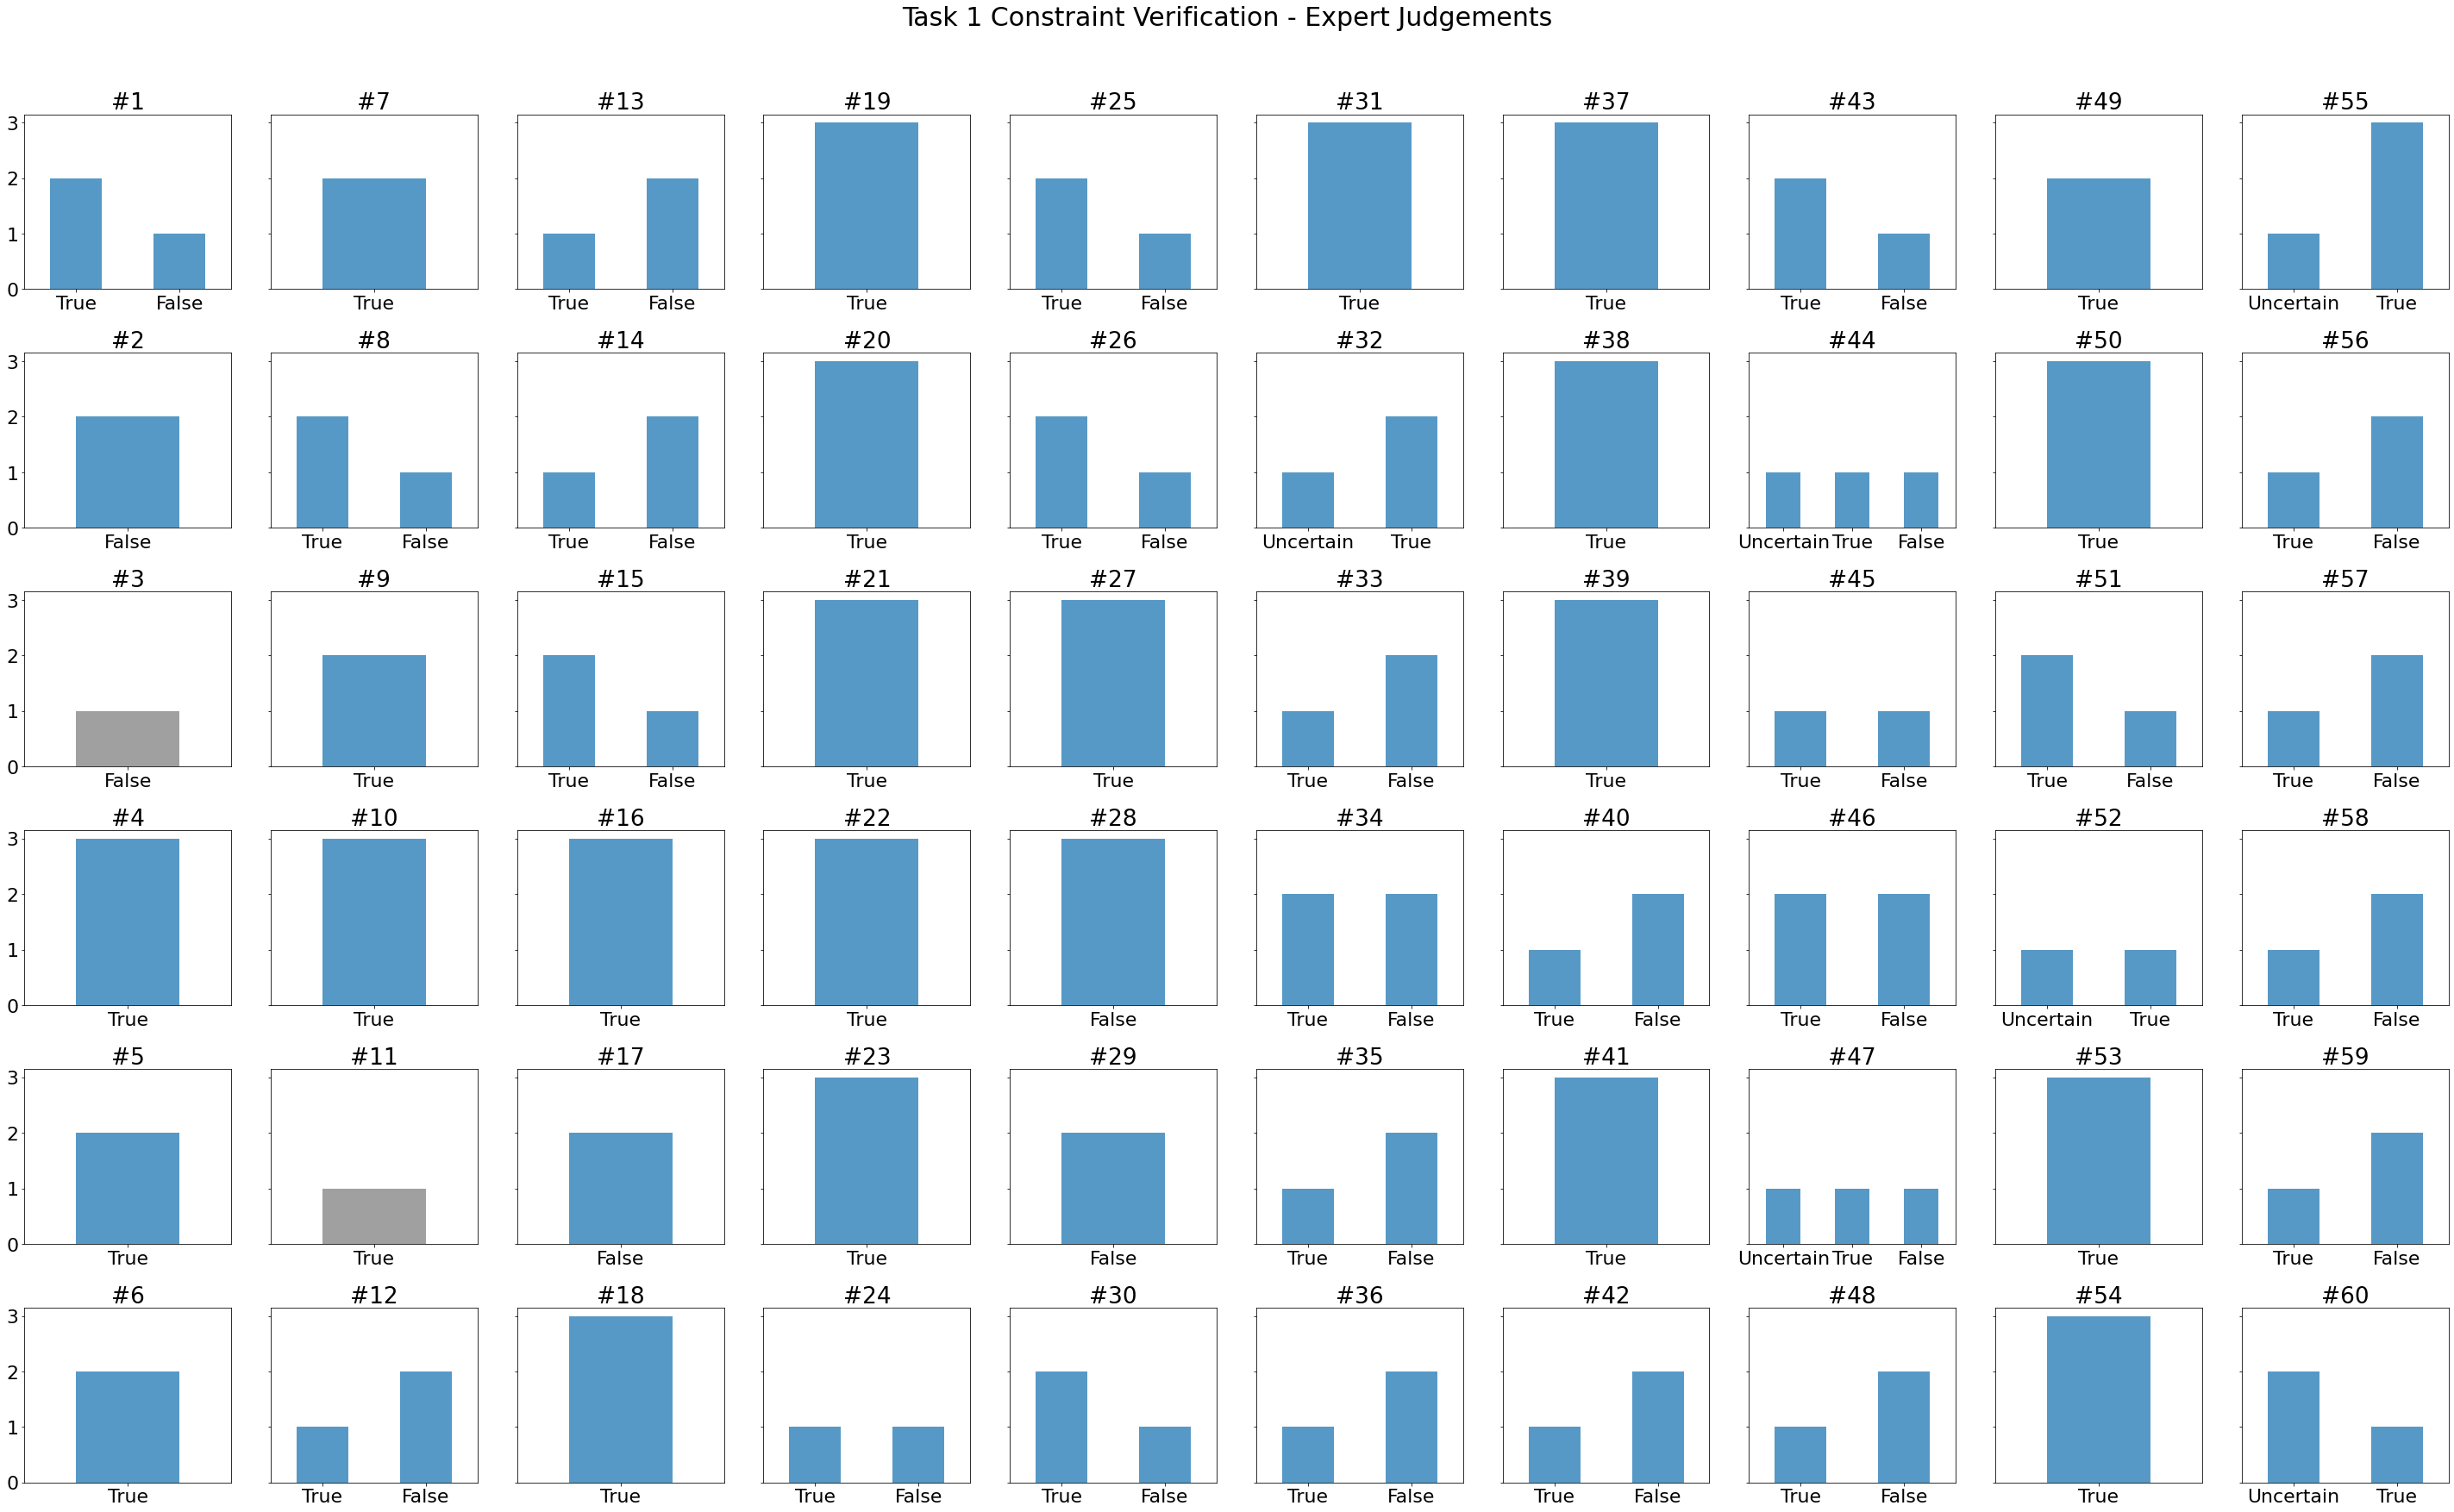

In [20]:
plt.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(6, 10, figsize=(40,25),sharey=True)
i=0;
j=0;


for constraint in df["Input.ID"].unique():
    sentencenum = sentences[sentences["Input.ID"]==constraint]["SentenceNum"].values[0]
    workersAsnwers = df[(df["Input.ID"] == constraint)]
    authorsConstraint =df[df["Input.ID"] == constraint]["Input.Constraint"].values[0]
    s = pd.Series(data = workersAsnwers.isConstraint.values)
    if((len(s.value_counts().values) == 1) & (s.value_counts().values[0]==1)):
        s.value_counts().plot(kind='bar',ax=axes[i,j],alpha=0.75, rot=0,color="gray",title="#"+str(sentencenum))
        #if(authorsConstraint):
            #axes[i,j].set_facecolor("#F0FFFD")
    else:
        s.value_counts().sort_index(ascending=False).plot(kind='bar',ax=axes[i,j],alpha=0.75, rot=0,title="#"+str(sentencenum))
        #if(authorsConstraint):
            #axes[i,j].set_facecolor("#F0FFFD")   

    i=i+1
    if(i==6):
        j+=1
        i=0  
fig.suptitle("Task 1 Constraint Verification - Expert Judgements", fontsize=30)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig('agreementConstraint.png')
plt.show()

#Shows that for > 50% of the data there was no agreement among the experts)
# Gray -> only one expert evaluation

In [21]:
sentences.head()

Input.ID Input.Constraint  Input.BATCH isConstraintMajority  \
0         2             True            2                 True   
3         4            False            2                False   
5         6             True            2                False   
6         8             True            2                 True   
9        12             True            2                 True   

  isRuleValidtMajority RuleDefectMajority  Evaluators  SentenceNum  
0                 True                              3            1  
3                                                   2            2  
5                                                   1            3  
6                 True                              3            4  
9                 True                              2            5

In [22]:
categories = {}
categories["Expert Agreement"]=0
categories["Expert Disagreement"]=0
categories["Single Judgement"]=0

for constraint in df["Input.ID"].unique():
    #sentencenum = sentences[sentences["Input.ID"]==constraint]["SentenceNum"].values[0]
    workersAsnwers = df[(df["Input.ID"] == constraint)]
    #authorsConstraint =df[df["Input.ID"] == constraint]["Input.Constraint"].values[0]
    s = pd.Series(data = workersAsnwers.isConstraint.values)
    if(len(s.value_counts())!= 1):
        categories["Expert Disagreement"] += 1
    else:
        if(s.value_counts()[0] == 1):
            categories["Single Judgement"] += 1   
        else:  
            categories["Expert Agreement"] += 1
            
classification={}   
classification["Constraint"] = 0
classification["Not-Constraint"] = 0
classification["Unclear"] = 0

for c in sentences["isConstraintMajority"]:

    if(c=="True"):
        classification["Constraint"] +=1
        continue;
    if(c=="False"):
        classification["Not-Constraint"] +=1
        continue;
    classification["Unclear"] +=1    

print(classification)        
print(categories)

{'Constraint': 34, 'Not-Constraint': 18, 'Unclear': 8}
{'Expert Agreement': 27, 'Expert Disagreement': 31, 'Single Judgement': 2}


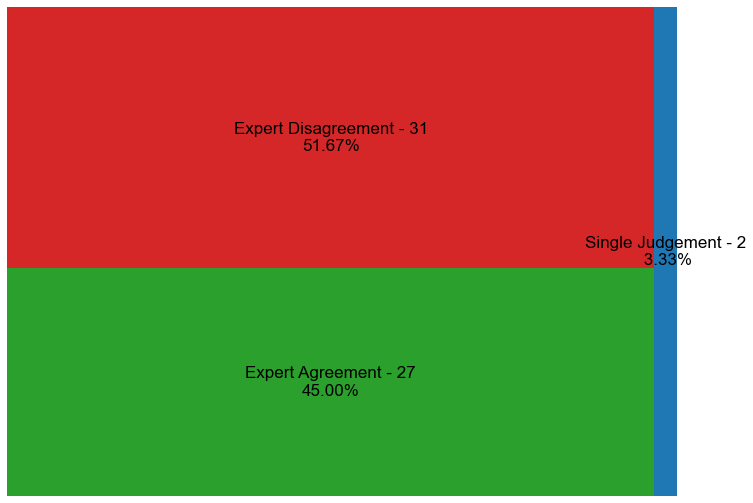

In [23]:
#Visualization of Agreement 

font = {'size' : 17, 'family': "Arial"} # Change font size here
plt.rc('font', **font)
colors = plt.cm.Spectral(np.linspace(0,1,len(categories)))
sizes=list(categories.values())
label=list(categories.keys())
lables_with_percentage = [i+" - "+str(categories[i])+"\n"+ str('{:5.2f}'.format(categories[i]/60*100)) + "%" for i in categories.keys()]
plt.figure(figsize=(12,9)) #Change figure size here
squarify.plot(sizes=sizes, label=lables_with_percentage, color=["#2CA02C","#D62728","#1F77B4"] )
plt.axis('off')
plt.savefig("task1_agreement_treemap.png")
plt.show()

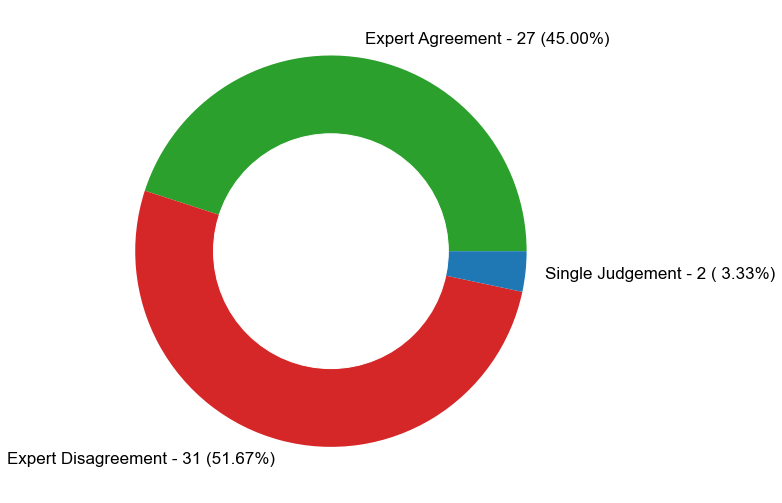

In [24]:
lables_with_percentage = [i+" - "+str(categories[i])+" ("+ str('{:5.2f}'.format(categories[i]/60*100)) + "%)" for i in categories.keys()]


plt.figure(figsize=(12,9))
plt.pie(sizes, labels = lables_with_percentage,colors=["#2CA02C","#D62728","#1F77B4"])
circle = plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig("task1_agreement_donut.png")
plt.show()

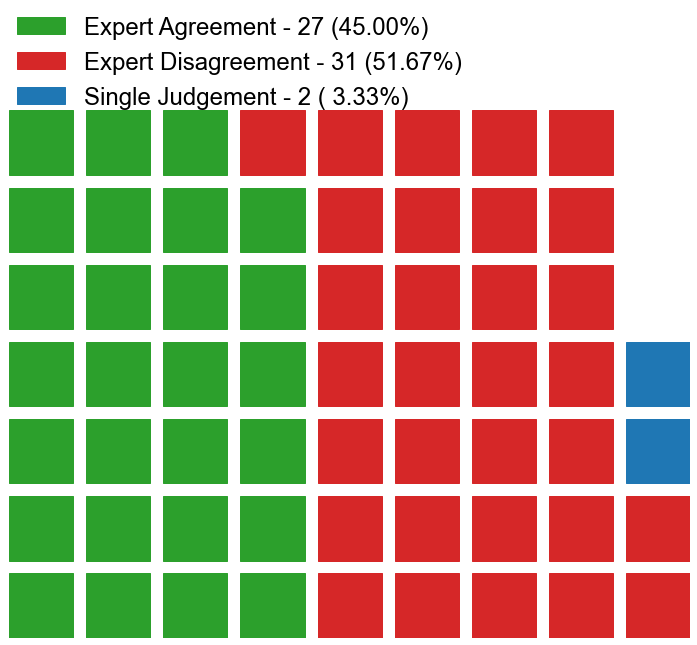

In [25]:

fig = plt.figure(
    FigureClass=Waffle, 
    #rows=6, 
    columns=9, 
    values=sizes,
    labels=lables_with_percentage,
    figsize=(10, 10),
    legend={'loc': 'upper left', 'bbox_to_anchor': (-0.02, 1.22), 'fontsize': 24, 'ncol':1,'frameon':False},
    colors=["#2CA02C","#D62728","#1F77B4"]
)
plt.savefig("task1_agreement_waffle.png")
plt.show()


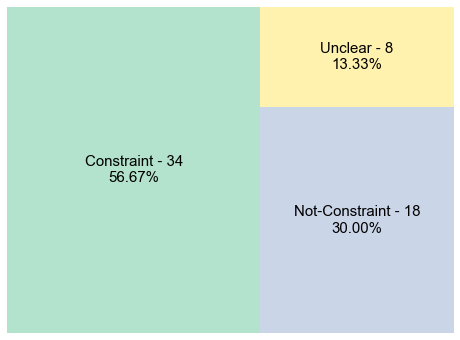

In [26]:
#Classification based on majority vote 

font = {'size' : 15} # Change font size here
plt.rc('font', **font)
sizes=list(classification.values())
label=list(classification.keys())
lables_with_percentage = [i+" - "+str(classification[i])+"\n"+ str('{:5.2f}'.format(classification[i]/60*100)) + "%" for i in classification.keys()]
plt.figure(figsize=(8,6)) #Change figure size here
squarify.plot(sizes=sizes, label=lables_with_percentage, color=plt.cm.Pastel2(np.linspace(0,1,4)) )
plt.axis('off')
plt.savefig("task1_classification_treemap.eps")
plt.show()

In [27]:
mapping_sentences = {}
sentences_authors = {}
sentences_experts = {}

for index,row in sentences.iterrows():
    id = row['Input.ID']
    author_classification = row['Input.Constraint']
    expert_majority = row['isConstraintMajority']
    if("," in expert_majority):
        expert_majority = "Uncertain"
    
    if(author_classification in mapping_sentences):
        if(expert_majority in mapping_sentences[author_classification]):
            mapping_sentences[author_classification][expert_majority] +=1
        else:
            mapping_sentences[author_classification][expert_majority] = 1
    else:
        mapping_sentences[author_classification] = {}
        mapping_sentences[author_classification][expert_majority] = 1 

        
    if (author_classification in sentences_authors):
        sentences_authors[author_classification] = sentences_authors[author_classification] + 1
    else:
        sentences_authors[author_classification] = 1
    if (expert_majority in sentences_experts):
        sentences_experts[expert_majority] = sentences_experts[expert_majority] + 1
    else:
        sentences_experts[expert_majority] = 1    

    
for res in mapping_sentences: 
    print("{0}: {1}".format(res, mapping_sentences[res]))  

True: {'True': 25, 'False': 13, 'Uncertain': 5}
False: {'False': 5, 'True': 9, 'Uncertain': 3}


In [28]:
print("Total number of sentences (auhtors)", sum(sentences_authors.values()))
print("Authors:", sentences_authors)
print("Total number of sentences (experts)", sum(sentences_experts.values()))
print("Experts:",sentences_experts)


Total number of sentences (auhtors) 60
Authors: {'True': 43, 'False': 17}
Total number of sentences (experts) 60
Experts: {'True': 34, 'False': 18, 'Uncertain': 8}


In [29]:
names = []
names_values = []
colors = {}

for res in mapping_sentences: 
    if res not in names: 
        names.append(res)
        label = res+" - "+str(sentences_authors[res])
        #names_values.append(label)
    for expertType in mapping_sentences[res]:
        if expertType not in names: 
            names.append(expertType)
            if (res in sentences_experts): 
                label = res+" - "+str(sentences_experts[res])
                #names_values.append(label)
            else:
                label = res+" - "+str(0)
            
            
mappingExpertType = []
mappingAuthorType = []
mappingCount = []

#mappingColors = []

for res in mapping_sentences: 
    #if res not in colors: 
      #  colors[res] = px.colors.qualitative.Light24[cntColors]
    for expertType in mapping_sentences[res]:
       # if expertType not in colors: 
        #    colors[expertType] = px.colors.qualitative.Light24[cntColors]
        mappingAuthorType.append(names.index(res))
        mappingExpertType.append(names.index(expertType) + len(names))
        mappingCount.append(mapping_sentences[res][expertType])
        
#for name in names:
 #   mappingColors.append(colors[name])

#mappingColors = np.concatenate([mappingColors,mappingColors])
#mappingColors = ['#ABEBC6','#F1948A','#EBDEF0','#ABEBC6','#F1948A','#EBDEF0']

mappingColors = ["#2CA02C","#D62728","#1F77B4","#2CA02C","#D62728","#1F77B4"  ]

names = []
names_values_authors = []
names_values_experts = []

for res in mapping_sentences: 
    if res not in names: 
        names.append(res)
    for expertType in mapping_sentences[res]:
        if expertType not in names: 
            names.append(expertType)
            
for res in names:
    if (res in sentences_authors): 
        label = res.replace("True","Constraint").replace("False","Not-Constraint")+" ("+str(sentences_authors[res])+")"
    else:
        label = res.replace("True","Constraint").replace("False","Not-Constraint")+" ("+str(0) +")"
    names_values_authors.append(label)

    if (res in sentences_experts): 
        label = res.replace("True","Constraint").replace("False","Not-Constraint")+" ("+str(sentences_experts[res])+")"
    else:
        label = res.replace("True","Constraint").replace("False","Not-Constraint")+" ("+str(0)+")"
    names_values_experts.append(label)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      #line = dict(color = "black", width = 0.5),
      label = names_values_authors + names_values_experts,
      color = mappingColors
    ),
    link = dict(
      source = mappingAuthorType,
      target = mappingExpertType,
      value = mappingCount
     
  ))])

title_text="authors' classification vs experts' classification (majority vote)"
fig.update_layout(font_size=17,autosize=False, width=700,height=600)#, title = title_text)
fig.write_html("Classification_Mapping.html")
fig.show()


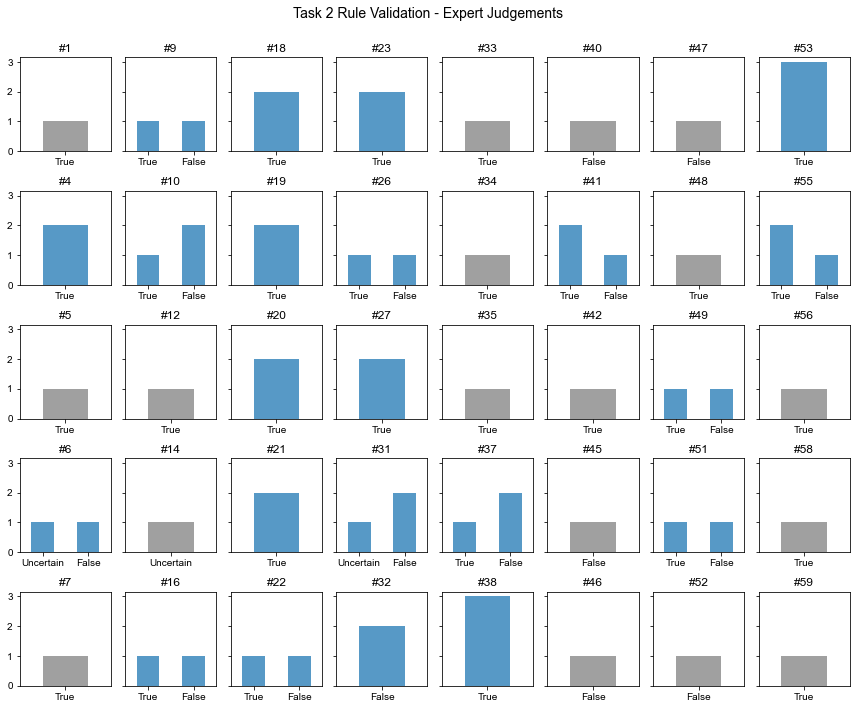

In [30]:

plt.rcParams.update({'font.size': 10})


fig, axes = plt.subplots(5, 8, figsize=(12,10),sharey=True)
i=0;
j=0;
for constraint in df["Input.ID"].unique():
    sentencenum = sentences[sentences["Input.ID"]==constraint]["SentenceNum"].values[0]
    workersAsnwers = df[(df["Input.ID"] == constraint)]
    s = pd.Series(data = workersAsnwers[workersAsnwers.isRuleValid != ""].isRuleValid.values)
    if(s.value_counts().empty):
        continue
    if((len(s.value_counts().values) == 1) & (s.value_counts().values[0]==1)):
        s.value_counts().plot(kind='bar',ax=axes[i,j],alpha=0.75, rot=0,color="gray",title="#"+str(sentencenum))
    else:
        s.value_counts().sort_index(ascending=False).plot(kind='bar',ax=axes[i,j],alpha=0.75, rot=0,title="#"+str(sentencenum))
    i=i+1
    if(i==5):
        j+=1
        i=0 
        
fig.suptitle("Task 2 Rule Validation - Expert Judgements", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig('agreementRuleValidation.png')
plt.show()
#Almost haf of the defects were identified by a single expert (no agreement calculated)

26 ['incorrectandincomplete' nan 'incorrect']
31 ['incomplete' 'incorrect']
32 [nan 'incorrect' 'incomplete']
37 ['incomplete' nan 'incorrect']


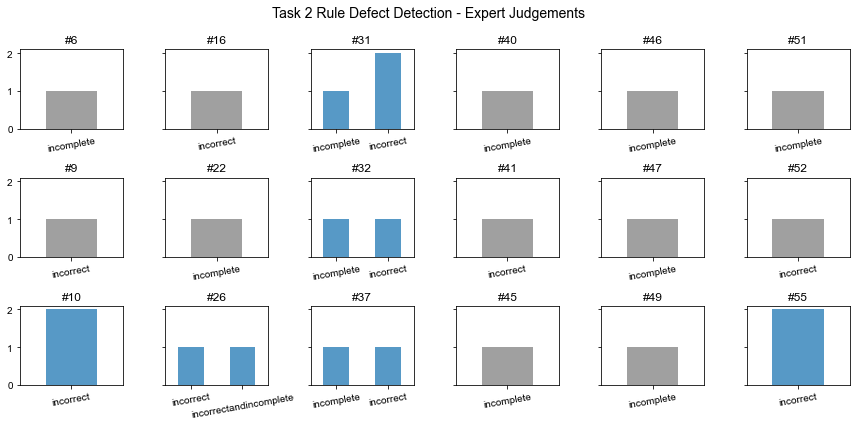

In [31]:
defects={}
defects["incomplete"] = 0
defects["incorrect"] = 0

defects_3={}
defects_3["incomplete"] = 0
defects_3["incorrect"] = 0
defects_3["incorrect and incomplete"] = 0

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(3, 6, figsize=(12,6),sharey=True)
i=0;
j=0;
for constraint in df["Input.ID"].unique():
    #print("###",constraint,"###")
    sentencenum = sentences[sentences["Input.ID"]==constraint]["SentenceNum"].values[0]
    workersAsnwers = df[(df["Input.ID"] == constraint)]
    workersAsnwers=workersAsnwers.reset_index(drop=True)
    #print(workersAsnwers["Answer.RuleSetDefect"].values)
    s = pd.Series(data = workersAsnwers["Answer.RuleSetDefect"].values)
    if(s.value_counts().empty):
        continue
    if((len(s.value_counts().values) == 1) & (s.value_counts().values[0]==1)):
        s.value_counts().plot(kind='bar',ax=axes[i,j],alpha=0.75, rot=10,color="gray",title="#"+str(sentencenum))
        #single answer -> count once per rule
        for value in s.unique():
            if(value=="incomplete"):
                defects["incomplete"] += 1
                defects_3["incomplete"] += 1
            if(value=="incorrect"):
                defects["incorrect"] += 1
                defects_3["incorrect"] += 1
            if(value=="incompleteandincorrect"):
                defects_3["incorrect and incomplete"] += 1
    else:
        s.value_counts().sort_index(ascending=True).plot(kind='bar',ax=axes[i,j],alpha=0.75, rot=10,title="#"+str(sentencenum))
        #multiple asnwers -> count all unique values once per rule
        added=False
        if((("incomplete" in s.unique()) and ("incorrect" in s.unique())) or ("incorrectandincomplete" in s.unique())):
            defects_3["incorrect and incomplete"] += 1
            added = True
            print(sentencenum,s.unique())
        for value in s.unique():
            if(value =="incomplete"):
                defects["incomplete"] += 1
                if(not added):
                    defects_3["incomplete"] += 1
            if(value =="incorrect"):
                defects["incorrect"] += 1
                if(not added):
                    defects_3["incorrect"] += 1
            if(value =="incorrectandincomplete"):
                #defects["incorrectandincomplete"] += 1
                if "incorrect" not in s.unique():
                    defects["incorrect"] += 1 
                if "incomplete" not in s.unique():  
                    defects["incomplete"] += 1
                    
    i=i+1
    if(i==3):
        j+=1
        i=0 
        
fig.suptitle("Task 2 Rule Defect Detection - Expert Judgements", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)       
plt.savefig('agreementRuleDefect.png')
plt.show()

#shows that most defects were idetified by a singke expert so no agreement calucation is possible
#for almost all of the rest of the rules the experts did not reach an agreement 

In [32]:
print(defects_3)

{'incomplete': 8, 'incorrect': 6, 'incorrect and incomplete': 4}


Defects: {'incomplete': 8, 'incorrect': 6, 'incorrect and incomplete': 4}


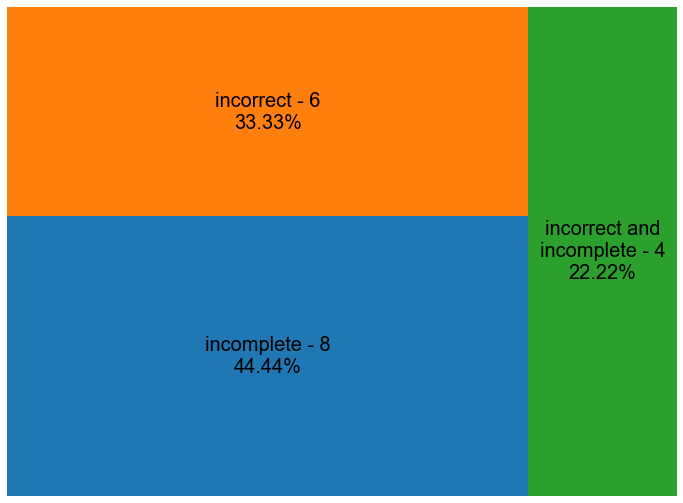

In [33]:
#Deffect occurances 
print("Defects:",defects_3)
font = {'size' : 20, 'family': "Arial"} # Change font size here
plt.rc('font', **font)
sizes=list(defects_3.values())
label=list(defects_3.keys())
lables_with_percentage = [i.replace(" and "," and\n")+" - "+str(defects_3[i])+"\n"+ str('{:5.2f}'.format(defects_3[i]/18*100)) + "%"  
                          for i in defects_3.keys()]
plt.figure(figsize=(12,9)) #Change figure size here
squarify.plot(sizes=sizes, label=lables_with_percentage,color= px.colors.qualitative.D3 )
#plt.title("Task 2: Rule Defect Detection - Expert Judgements", fontsize=14)
plt.axis('off')
plt.savefig("task3_defects_treemap.png")
plt.show()


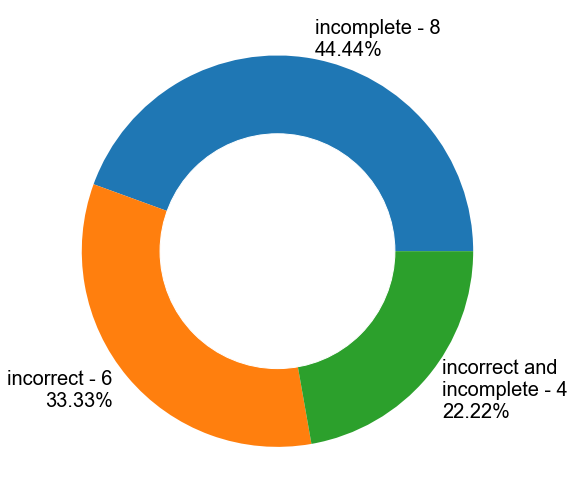

In [34]:
plt.figure(figsize=(12,9))
plt.pie(sizes, labels = lables_with_percentage)
circle = plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig("task3_defects_donut.png")
plt.show()

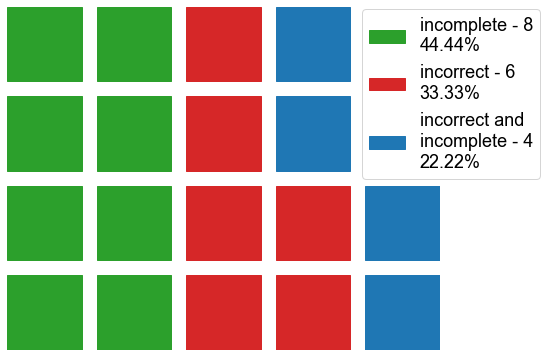

In [35]:
fig = plt.figure(
    FigureClass=Waffle, 
    rows=4, 
    #columns=5, 
    values=sizes,
    labels=lables_with_percentage,
    figsize=(8, 10),
    legend={'loc': 'upper left', 'bbox_to_anchor': (0.8, 1.02), 'fontsize': 18},
    colors=["#2CA02C","#D62728","#1F77B4"]
)
plt.savefig("task1_agreement_waffle.png")
plt.show()